# Amortized LDA implementation

## Loading libraries

In [1]:
# Load libraries
import logging
import pyro

import pandas as pd

from zzz_utils import *
from amortized_lda import *

import matplotlib.pyplot as plt

logging.basicConfig(format="%(relativeCreated) 9d %(message)s", level=logging.INFO)

pyro.clear_param_store()
pyro.set_rng_seed(123)

## Amortized LDA graphical model

First we simulate a toy dataset to render the Pyro models.

In [2]:
nTopics = 3    # Topics
nCells = 50    # Cells
nRegions = 100 # Regions
N = [30] * nCells # Cells size

# Simulate data
obj = simulate_lda_dataset(nTopics = nTopics, nCells = nCells, 
                           nRegions = nRegions, N = N, 
                           a = [1] * nTopics, b = [1] * nRegions)
# transpose so it matches Pyro's input
D = torch.from_numpy(obj['D'].transpose())

Below we define the LDA model with Pyro. Note that data D is a matrix of nCounts x nCells, and here we assume that nCounts is the same across cells.

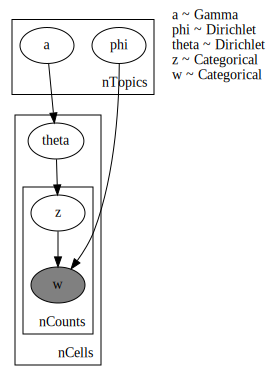

In [3]:
pyro.clear_param_store()
pyro.render_model(amortized_lda_model, model_args=(D, nTopics, nRegions), 
                  render_distributions=True, render_params=True)

## Amortized LDA guide (variational approximation)

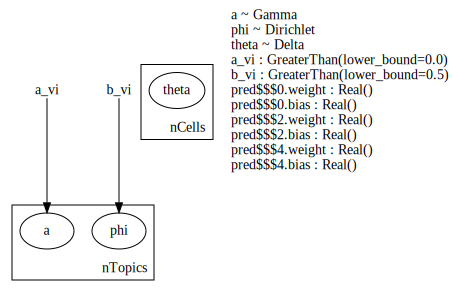

In [4]:
# Create NN predictor
layer_sizes = "100-100"
pred = nn_predictor(nTopics, nRegions, layer_sizes)
guide = functools.partial(amortized_lda_guide, pred)
pyro.render_model(guide, model_args=(D, nTopics, nRegions, 20), 
                  render_distributions=True, render_params=True)

# Testing variational inference

## Simulate data
We use simulated data from the LDA model to test the amortized LDA inference performance. 
I.e. how close are inferred values to true values used to simulate the data. 

__Note__ there is the known identifiability issue of mixture and mixed-membership models, however we still would expect cell assignments to be consistent with the simulated data.


In [6]:
# Simulate data
nTopics = 2    # Topics
nCells = 1000    # Cells
nRegions = 300 # Regions
N = [100] * nCells # Cells size
a = [1/5] * nTopics
b = [1/10] * nRegions
# Simulate data
obj = simulate_lda_dataset(nTopics = nTopics, nCells = nCells, 
                           nRegions = nRegions, N = N, 
                           a = a, b = b)
# transpose so it matches Pyro's input
D = torch.from_numpy(obj['D'].transpose())

In [7]:
D.shape # simulated data dims nCounts x nCells

torch.Size([100, 1000])

In [8]:
obj['theta_true'][1:10, ] # first 10 cells prob assignments to each topic

array([[9.94835815e-01, 5.16418480e-03],
       [2.54573180e-02, 9.74542682e-01],
       [5.20898175e-01, 4.79101825e-01],
       [9.27515786e-02, 9.07248421e-01],
       [7.18822213e-02, 9.28117779e-01],
       [8.53590854e-09, 9.99999991e-01],
       [3.24913217e-03, 9.96750868e-01],
       [9.82831644e-01, 1.71683556e-02],
       [9.15326830e-01, 8.46731699e-02]])

In [9]:
obj['phi_true'][:, 1:10].transpose() # first 10 region-topic probs

array([[1.30291809e-07, 2.98236497e-06],
       [2.56168520e-04, 3.43882945e-10],
       [3.35069342e-05, 3.65638864e-05],
       [1.01397656e-05, 3.33171745e-03],
       [4.55111961e-02, 2.53285951e-02],
       [3.90901658e-02, 4.38038917e-02],
       [5.81091949e-06, 2.12537077e-11],
       [3.49017392e-03, 4.27418260e-03],
       [1.25760088e-10, 1.65176933e-06]])

## Fit AmortizedLDA 

To perform inference for Amortized LDA with use ClippedAdam to optimize a 
__trace implementation of ELBO-based SVI__ ('TraceEnum_ELBO'), which supports exhaustive enumeration 
over discrete sample sites, in our case latent topic assignment __z__.

In [10]:
pyro.clear_param_store()

obj = fit_amortized_lda(D = D, nTopics = nTopics, nRegions = nRegions, nSteps = 3000, batch_size=64, lr = 0.01, seed = 123)

    45914 ----------------------------------------
    45915 Fitting 1000 cells
    45917 Step	Loss
    46009     0	600314.375
    48335   100	532302.125
    50675   200	496541.625
    53025   300	463976.8125
    55364   400	456080.5
    57638   500	451331.5625
    59964   600	444733.9375
    62269   700	446153.84375
    64580   800	442691.1875
    66809   900	443095.6875
    69057  1000	440314.375
    71214  1100	441858.5625
    73370  1200	444672.34375
    75558  1300	439562.25
    77865  1400	438296.8125
    80150  1500	438930.0
    82434  1600	438684.875
    84638  1700	437521.8125
    86783  1800	438194.3125
    89047  1900	440321.28125
    91334  2000	440755.0
    93564  2100	440419.09375
    95707  2200	437900.9375
    97904  2300	436933.0625
   100223  2400	438098.40625
   102438  2500	439756.6875
   104605  2600	437114.90625
   106770  2700	436134.59375
   108946  2800	437566.90625
   111097  2900	439008.9375
   113228 final loss = 435925.15625


Here we plot the ELBO loss during optimisation.

Text(0, 0.5, 'ELBO loss')

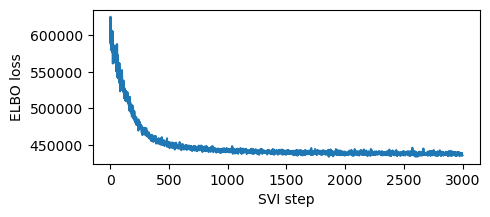

In [11]:
# plot ELBO losses
losses = obj['losses']

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

## Assessing inferred parameters

Below we show estimates of the inferred model parameters. To show this, here I am just taking a sample from the 
posterior fit (i.e. calling the guide with the optimized set of variational parameters). Surely this is not the optimal way to summarise the posterior fit. 

__However__, if I take multiple samples from the posterior and subseqently summarise the posterior samples (e.g. by median), due to label switching that occurs when sampling 
$\theta \sim Dir(\alpha)$, the posterior mode will be useless. 

__TODO__ 

1. Define a better way to summarize the posterior distribution from posterior samples. E.g. by fixing the label switching problem, post-hoc after sampling from the posterior (similar approach to mixture models).
2. Make posterior predictive checks.
3. Need to understand Pyro's `poutine`.


In [12]:
# Get the fitted guide object, from which we will sample from.
guide = obj['guide']

In [13]:
# A single sample from the guide
post_sample = guide(D = D, nTopics = nTopics, nRegions = nRegions, batch_size=64)

In [14]:
post_sample['alpha'] # posterior alpha

tensor([25.3592, 20.0332], grad_fn=<DivBackward0>)

In [15]:
post_sample['theta'][1:10, :] # posterior theta

tensor([[0.4733, 0.5267],
        [0.4733, 0.5267],
        [0.4733, 0.5267],
        [0.4733, 0.5267],
        [0.4733, 0.5267],
        [0.4733, 0.5267],
        [0.4733, 0.5267],
        [0.4733, 0.5267],
        [0.4733, 0.5267]], grad_fn=<SliceBackward0>)

In [16]:
post_sample['phi'][:, 1:10].detach().numpy().transpose() # posterior phi

array([[1.91718191e-05, 1.39551275e-05],
       [1.18228791e-05, 4.62941825e-04],
       [5.75541059e-10, 9.18168644e-06],
       [1.14342640e-03, 1.23976823e-03],
       [3.06162741e-02, 3.74106281e-02],
       [3.32487151e-02, 4.38332334e-02],
       [3.08050548e-05, 6.39301070e-05],
       [3.48611060e-03, 4.58849547e-03],
       [2.81286430e-05, 2.03426262e-05]], dtype=float32)

In [ ]:
# Extract optimized values of variational parameters

#for name, value in pyro.get_param_store().items():
#    print(name, pyro.param(name).data.cpu().numpy())

## Testing (ignore for now)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
obj['D_str'][2]

vectorizer = CountVectorizer(max_df=1.0, min_df=0, stop_words=None)
docs = torch.from_numpy(vectorizer.fit_transform(obj['D_str']).toarray())

vocab = pd.DataFrame(columns=['word', 'index'])
vocab['word'] = vectorizer.get_feature_names()
vocab['index'] = vocab.index

In [ ]:
docs.shape

In [ ]:
obj['D_freq']

In [ ]:
obj['D_tfidf']

In [ ]:
obj['D_freq']